In [3]:
import argparse
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from utils import *
import random
import numpy as np
import math
import os 
import scipy
import torch.nn as nn
from modified_stable_diffusion import ModifiedStableDiffusionPipeline
import PIL
from PIL import Image, ImageFilter,ImageEnhance
import commpy.utilities as util
import cv2
from diffusers.models import AutoencoderKL
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='diffusion watermark')
    parser.add_argument('--w_seed', default=0, type=int)
    parser.add_argument('--dataset', default='coco')
    parser.add_argument('--model_path', default='../stable-diffusion-v1-4')
    parser.add_argument('--image_length', default=512, type=int)
    parser.add_argument('--secret_length', default=48, type=int)
    parser.add_argument('--num_inference_steps', default=25, type=int)
    parser.add_argument('--guidancescale', default=5, type=float)
    parser.add_argument('--reverse_inference_steps', default=25, type=int)
    parser.add_argument('--model', default='./model48bit_finetuned_backup.pth', type=str)
    args =parser.parse_known_args()[0]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.set_printoptions(sci_mode=False,profile='full')
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    maxlength=150
    
# dataset
dataset, prompt_key = get_dataset(args)
dataset=promptdataset(dataset,prompt_key)
new_vae=torch.load('./disti.pth').to(device).to(torch.float32)
vae = AutoencoderKL.from_pretrained('../stable-diffusion-v1-4/vae', torch_dtype=torch.float16).to(device)
#model
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_path, subfolder='scheduler')
pipe = ModifiedStableDiffusionPipeline.from_pretrained(
        args.model_path,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        revision='fp16',
        )
pipe = pipe.to(device)

#diffusetrace
from encoder_decoder_pretrain.watermark_model import *
encoder=Watermark(secret_length=args.secret_length).to(device)
if args.model !=None:
    encoder.load_state_dict(torch.load(args.model))
encoder.eval()


/tmp/ipykernel_17841/595655903.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_vae=torch.load('./disti.pth').to(device).to(torch.float32)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_17841/595655903.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(args.model))


Watermark(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (mean_linear): Linear(in_features=4096, out_features=16384, bias=True)
  (var_linear): Linear(in_feat

  0%|          | 0/10 [00:00<?, ?it/s]

current prompt: A computer desk topped with a laptop computer with two monitors.


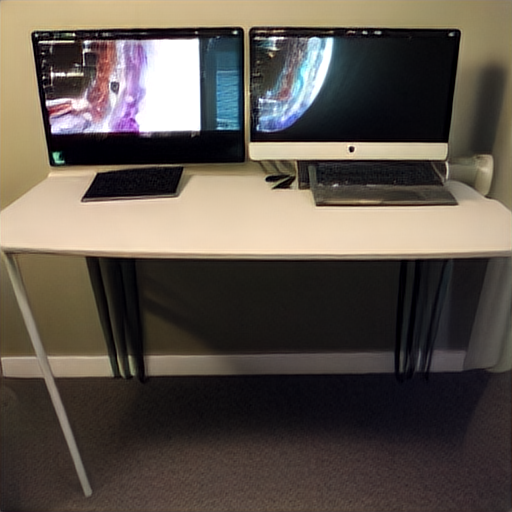

FileNotFoundError: [Errno 2] No such file or directory: '/root/watermark/DistriMark/exp/finetuned/0.png'

In [4]:
Metric,Loss,Error_correct=[],[],[]
Secret=[]
Prompts=[]
secret= torch.ones(48, dtype=torch.float32)
for m in tqdm(range(10)):
    initial_latents=get_random_latents(pipe,args)
    init_latents=initial_latents.detach().clone()
    Secret.append(secret)
    bina = torch.Tensor(secret).unsqueeze(-1).unsqueeze(-1).unsqueeze(0).to(device)
    bina = bina.expand(-1,-1,64,64)
    matrix1,mean,logvar=encoder(bina)
    mean=mean.reshape(-1,4,64,64)
    logvar=logvar.reshape(-1,4,64,64)
    eps = torch.randn_like(logvar)
    std = torch.exp(logvar / 2)
    matrix = eps * std + mean
    init_latents=matrix.half()

    prompt=dataset[random.randint(1, len(dataset))][0:maxlength]
    print(f"current prompt: {prompt}")
    latents=init_latents
    with torch.no_grad():
                        height,height = 512,512
                        do_classifier_free_guidance = args.guidancescale > 1.0
                        text_embeddings,negative_prompt_embeds = pipe.encode_prompt(
                            prompt, device, 1, do_classifier_free_guidance
                        )
                        if do_classifier_free_guidance:
                            text_embeddings = torch.cat([negative_prompt_embeds, text_embeddings])
                        pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
                        timesteps = pipe.scheduler.timesteps
                        for i, t in enumerate(timesteps):
                                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
                                noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[0]
                                if do_classifier_free_guidance:
                                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                                    noise_pred = noise_pred_uncond + args.guidancescale * (noise_pred_text - noise_pred_uncond)
                                latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                        latents = latents / 0.18215     
                        latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
                        
                        lat_fine = new_vae.decode(latents.float(),init_latents.float(), return_dict=False)[0].to(device)
                        lat_ori = vae.decode(latents, None,return_dict=False)[0].to(device)

                        img_fine = pipe.image_processor.postprocess(lat_fine.float().detach(), output_type='pil')[0]           
                        img_ori = pipe.image_processor.postprocess(lat_ori.detach(), output_type='pil')[0]
    img_fine.show()            
    Prompts.append(prompt)
    img_fine.save(f'./exp/finetuned/{m}.png')
    img_ori.save(f'./exp/original/{m}.png')


np.save('exp/secret.npy',Secret)
np.save('exp/prompts.npy',Prompts)

  0%|          | 0/1 [00:00<?, ?it/s]

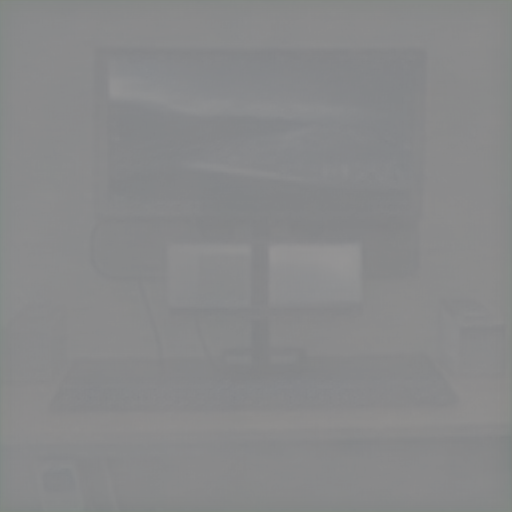

FileNotFoundError: [Errno 2] No such file or directory: '/root/watermark/DistriMark/exp/unauth_finetuned/0.png'

In [5]:
for m in tqdm(range(1)):
    ori=get_random_latents(pipe,args,batch_size=1)
    latents=ori
    with torch.no_grad():
                        height,height = 512,512
                        do_classifier_free_guidance = args.guidancescale > 1.0
                        text_embeddings,negative_prompt_embeds = pipe.encode_prompt(
                            prompt, device, 1, do_classifier_free_guidance
                        )
                        if do_classifier_free_guidance:
                            text_embeddings = torch.cat([negative_prompt_embeds, text_embeddings])
                        pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
                        timesteps = pipe.scheduler.timesteps
                        for i, t in enumerate(timesteps):
                                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
                                noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[0]
                                if do_classifier_free_guidance:
                                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                                    noise_pred = noise_pred_uncond + args.guidancescale * (noise_pred_text - noise_pred_uncond)
                                latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                        latents = latents / 0.18215     
                        latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
                        
                        lat_fine = new_vae.decode(latents.float(),ori.float(), return_dict=False)[0].to(device)
                        lat_ori = vae.decode(latents, None,return_dict=False)[0].to(device)

                        img_fine = pipe.image_processor.postprocess(lat_fine.float().detach(), output_type='pil')[0]           
                        img_ori = pipe.image_processor.postprocess(lat_ori.detach(), output_type='pil')[0]
                        
    torch.cuda.empty_cache()
    img_fine.show()
    img_fine.save(f'./exp/unauth_finetuned/{m}.png')
    img_ori.save(f'./exp/unauth_original/{m}.png')

In [ ]:
print(len(Prompts))